In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ichhadhari/indian-birds")

print("Path to dataset files:", path)

100%|██████████| 5.30G/5.30G [04:24<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ichhadhari/indian-birds/versions/1


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(path, 'Birds_25', 'train'),
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 30000 files belonging to 25 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(path, 'Birds_25', 'valid'),
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7500 files belonging to 25 classes.


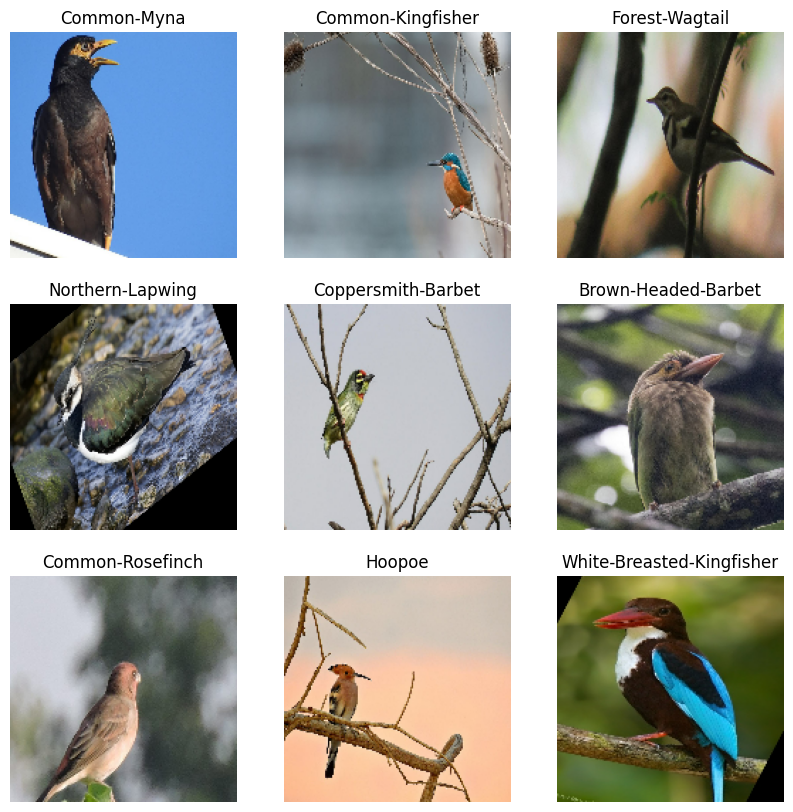

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print(class_names)

['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 188
Number of test batches: 47


In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

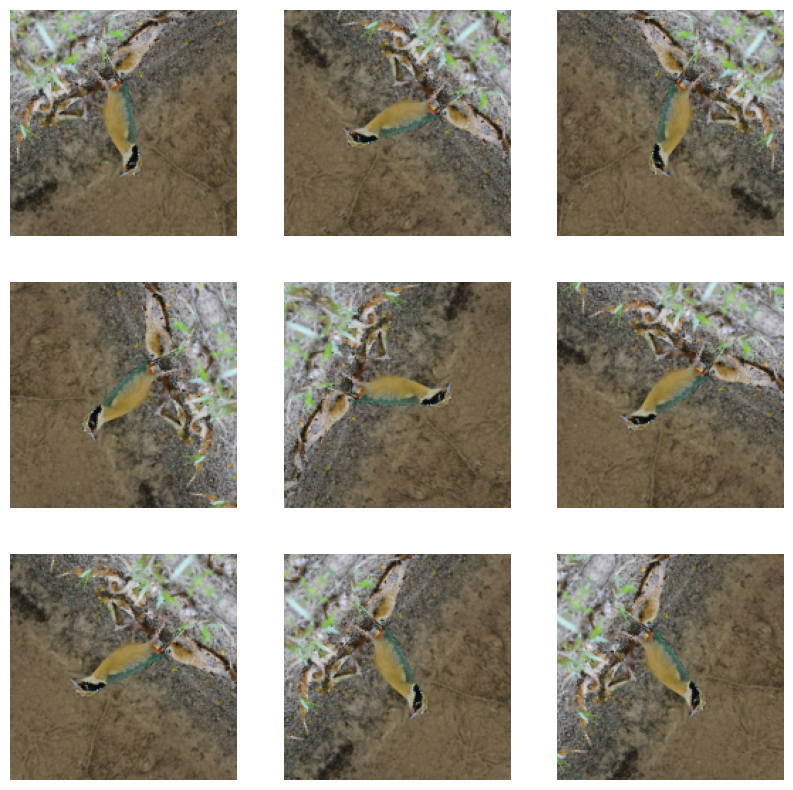

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
print(image_batch.shape)

(32, 160, 160, 3)


In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
num_classes = len(class_names)
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs= tf.keras.layers.Dense(num_classes, activation = 'log_softmax', name="outputs")(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,982,745 (11.38 MB)

 Trainable params: 724,761 (2.76 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

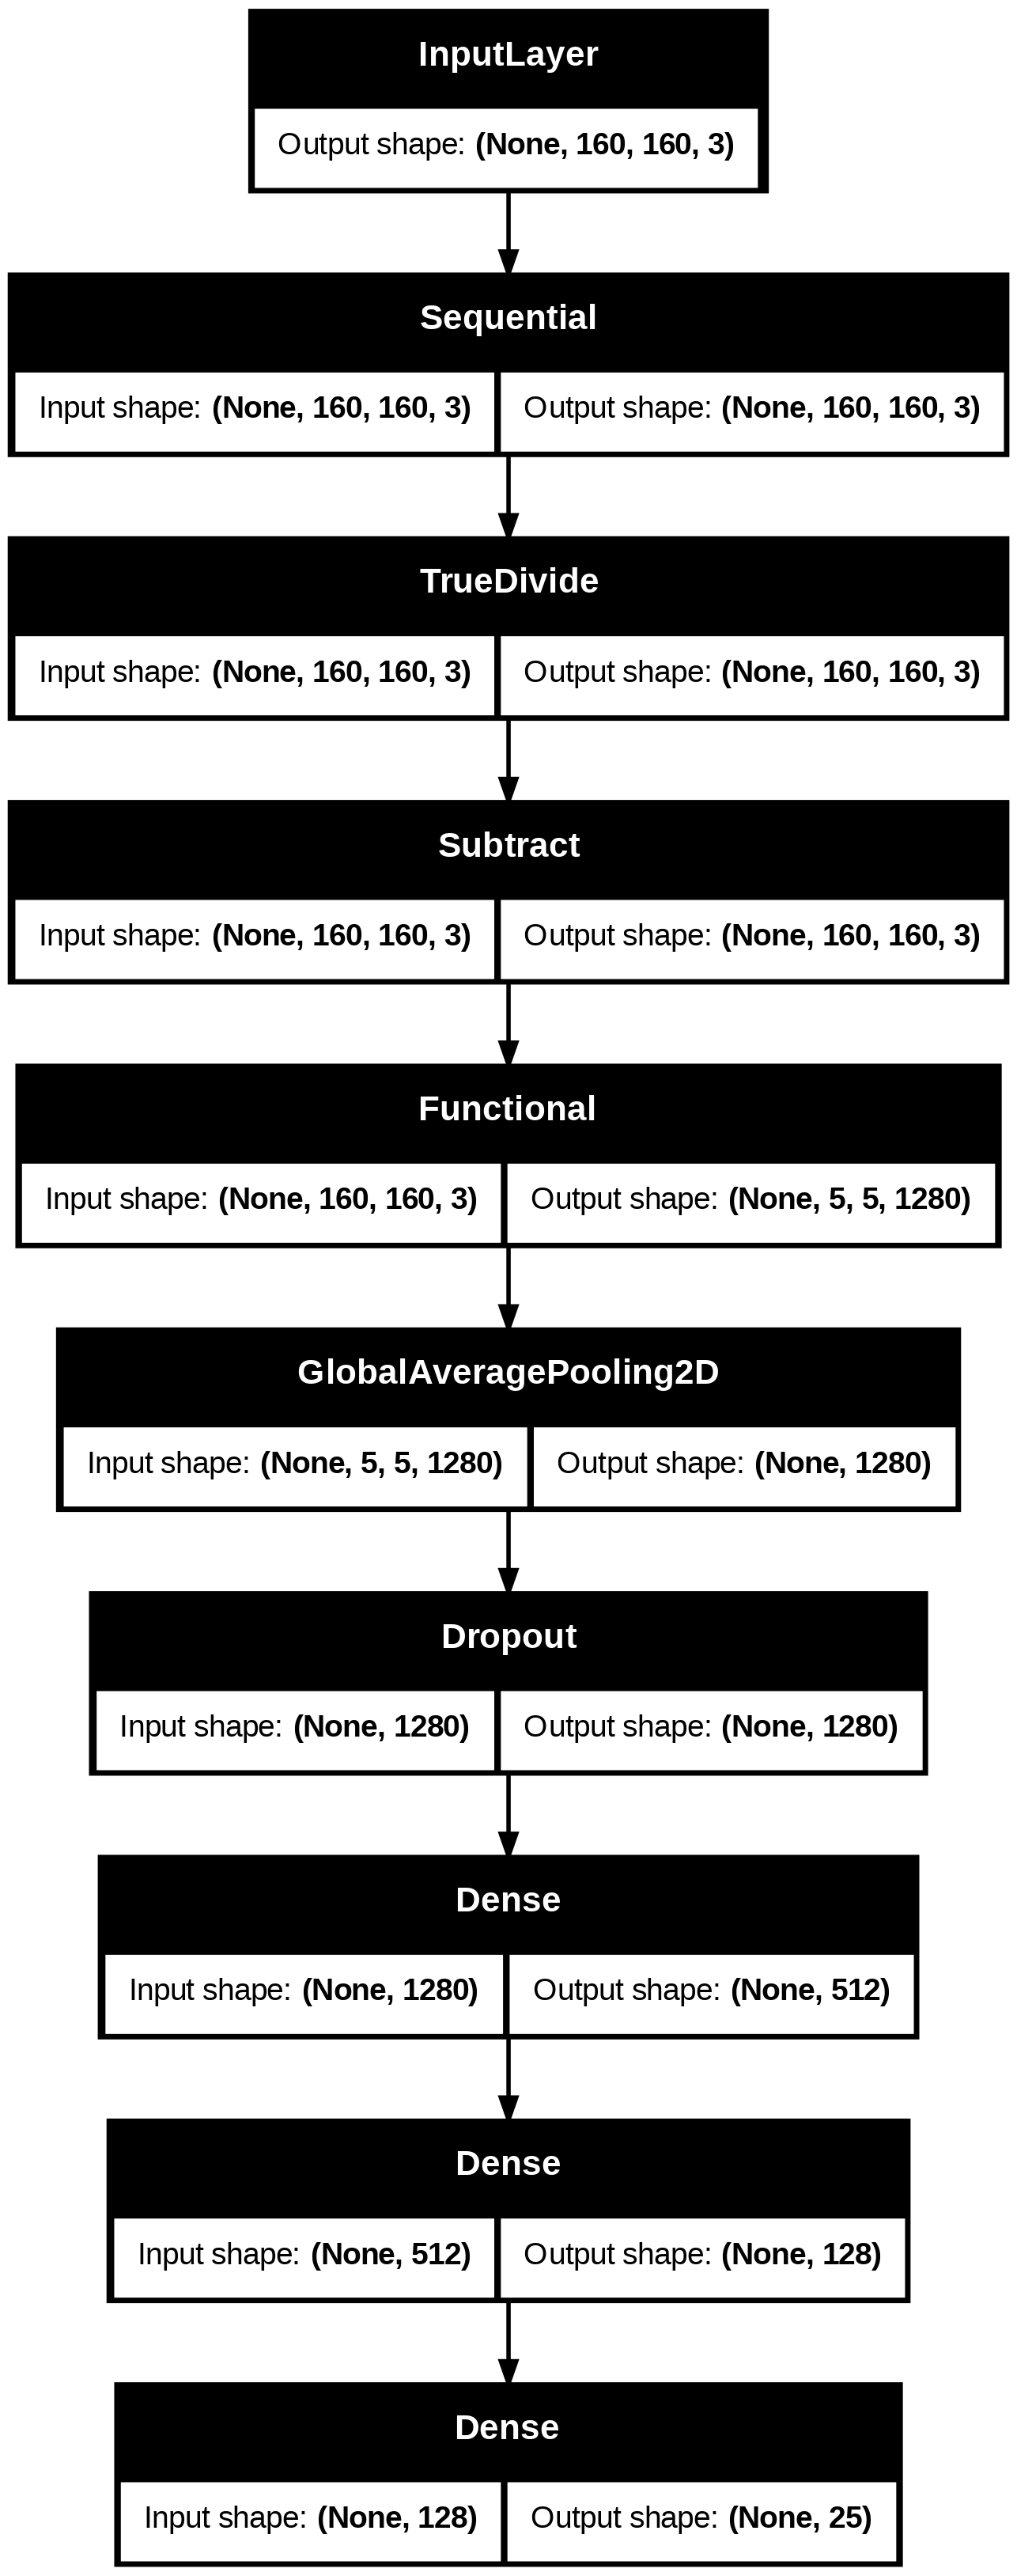

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 185s 190ms/step - accuracy: 0.5025 - loss: 1.7949 - val_accuracy: 0.8491 - val_loss: 0.5353
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 198s 188ms/step - accuracy: 0.8146 - loss: 0.6087 - val_accuracy: 0.8687 - val_loss: 0.4482
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 208s 195ms/step - accuracy: 0.8438 - loss: 0.5126 - val_accuracy: 0.8712 - val_loss: 0.4234
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step - accuracy: 0.8532 - loss: 0.4728 - val_accuracy: 0.8878 - val_loss: 0.3793
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 182s 194ms/step - accuracy: 0.8633 - loss: 0.4296 - val_accuracy: 0.8859 - val_loss: 0.3658
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 195s 187ms/step - accuracy: 0.8709 - loss: 0.4120 - val_accuracy: 0.8899 - val_loss: 0.3614
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 199s 184ms/step - accuracy: 0.8750 - loss: 0.4051 - val_accuracy: 0.8939 - val_loss: 0.3459
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 186ms/step - accuracy: 0.8784 -

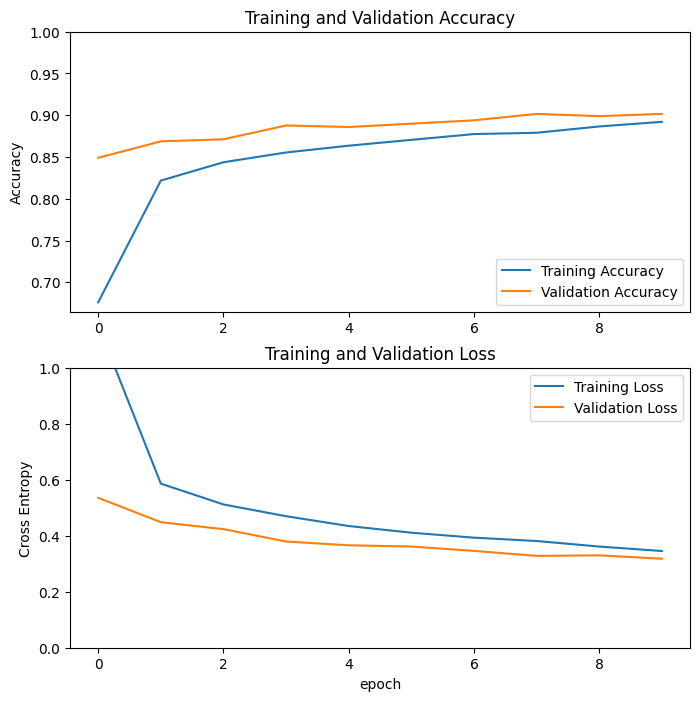

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy']
)

In [ ]:
model.summary()

In [30]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 209s 209ms/step - accuracy: 0.7884 - loss: 0.6679 - val_accuracy: 0.9124 - val_loss: 0.2837
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 197s 207ms/step - accuracy: 0.8657 - loss: 0.4246 - val_accuracy: 0.9129 - val_loss: 0.2783
Epoch 13/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 199s 204ms/step - accuracy: 0.8845 - loss: 0.3582 - val_accuracy: 0.9194 - val_loss: 0.2573
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 192s 205ms/step - accuracy: 0.9036 - loss: 0.2986 - val_accuracy: 0.9248 - val_loss: 0.2411
Epoch 15/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 204ms/step - accuracy: 0.9099 - loss: 0.2746 - val_accuracy: 0.9301 - val_loss: 0.2237
Epoch 16/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 207s 209ms/step - accuracy: 0.9174 - loss: 0.2554 - val_accuracy: 0.9336 - val_loss: 0.2160
Epoch 17/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 196s 209ms/step - accuracy: 0.9238 - loss: 0.2302 - val_accuracy: 0.9400 - val_loss: 0.2008
Epoch 18/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 202s 209ms/step - accuracy: 

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

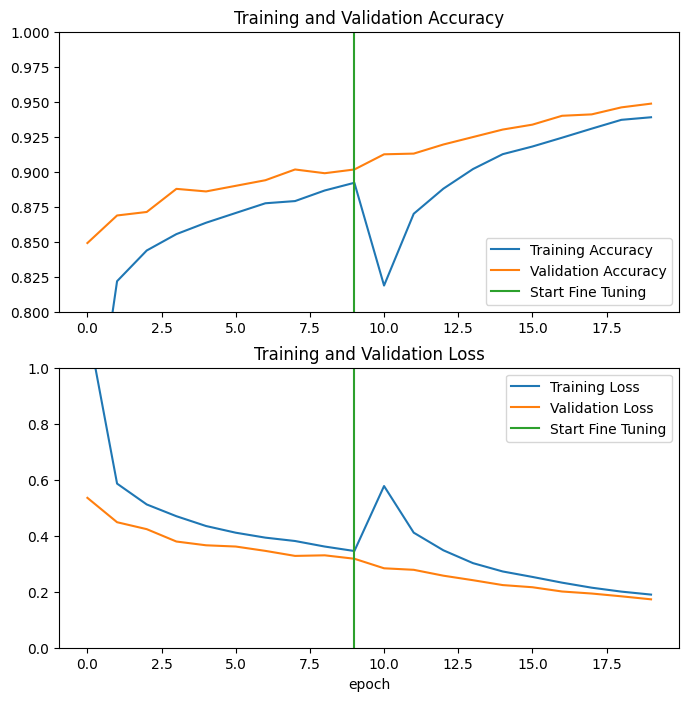

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


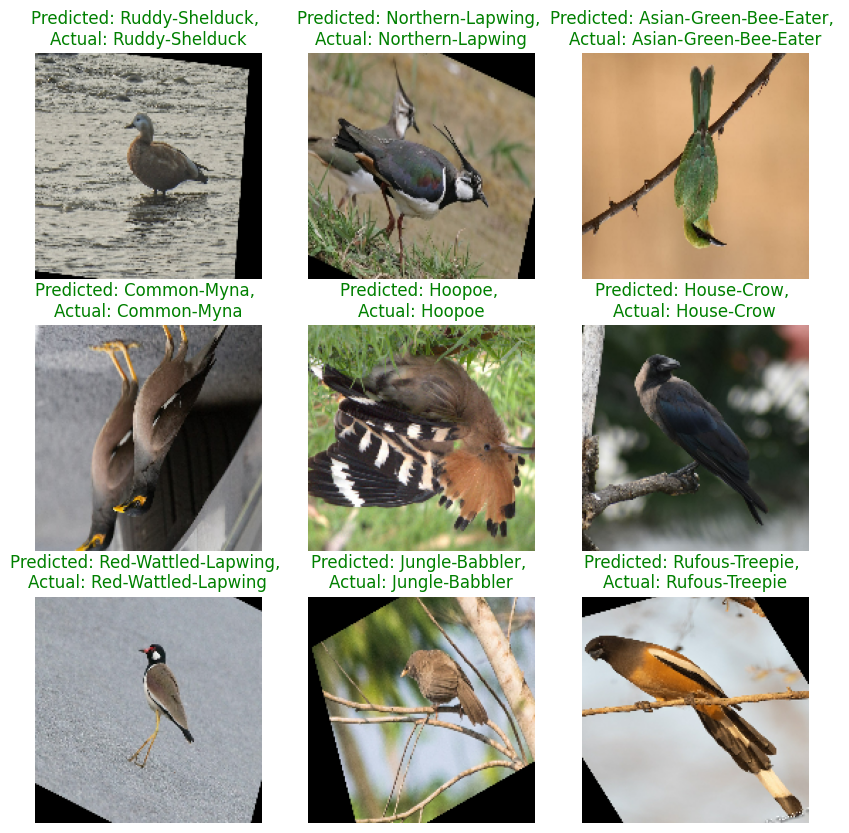

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    prediction = model.predict(images)
    ax = plt.subplot(3, 3, i+1)
    predicted_label = class_names[tf.argmax(prediction[i])] # get prediction for current image
    actual_label = class_names[labels[i]]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {predicted_label}, \nActual: {actual_label}",
              color = "green" if predicted_label == actual_label else "red")
    plt.axis("off")

In [34]:
model.evaluate(test_dataset)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9429 - loss: 0.1638


[0.17076100409030914, 0.9408244490623474]